# Named Entity Recognition with BERT in PyTorch

https://towardsdatascience.com/named-entity-recognition-with-bert-in-pytorch-a454405e0b6a

How to leverage a pre-trained BERT model for custom data to predict the entity each word in a text

When it comes to dealing with NLP problems, BERT oftentimes comes up as a machine learning model that we can count on in terms of its performance. The fact that it's been pre-trained on more than 2500M words and its bidirectional nature to learn information from a sequence of words makes it a powerful model to use.

I wrote about how we can leverage BERT for text classification before, and in this article, we are going to focus more on how to use BERT for named entity recognition(NER) task.

## What is NER?

NER is a task in NLP to identify and extract meaningful information (or we can call it entities) in a sentence or text. An entity can be a single word or even a group of words that refer to the same category.

As an example, let's say we the following sentence and we want to extrack information about a person's name from this sentence.
"The name is Bond, James Bond."
The first step of a NER task is to detect an entity. This can be a word or a group of words that refer to the same category. As an example:

- "Bond" -> an entity that consists of a single word
- "James Bond" -> an entity that consists of two words, but they are referring to the same category.

To make sure that our BERT model knows that an entity can be a single word or a group of words, then we need to provide information about the beginning and the ending of an entity on our training data via the so-called Inside-Outside-Beginning(IOB) tagging. We will see more about this on our dataset later in this article.

After detecting an entity, the next step in a NER task is to categorize the detected entity. The categories of an entity can be anything depending on our use case. Below is an example of categories of entities:

- Person
- Location
- Organization
- Location

These entities are basically the label of our data during the training process of our BERT model, which we will look at in detail later in the following section.

## BERT for NER

As previously mentioned, BERT is transformers-based machine learning model that will come in pretty handy if we want to solve NLP-related tasks.

What differentiates between BERT for text classification and the NER problem is how we set the output of the model. For a text classification problem, we only use the embedding vector output from the special [CLS] token, as you can see in the visualization below:

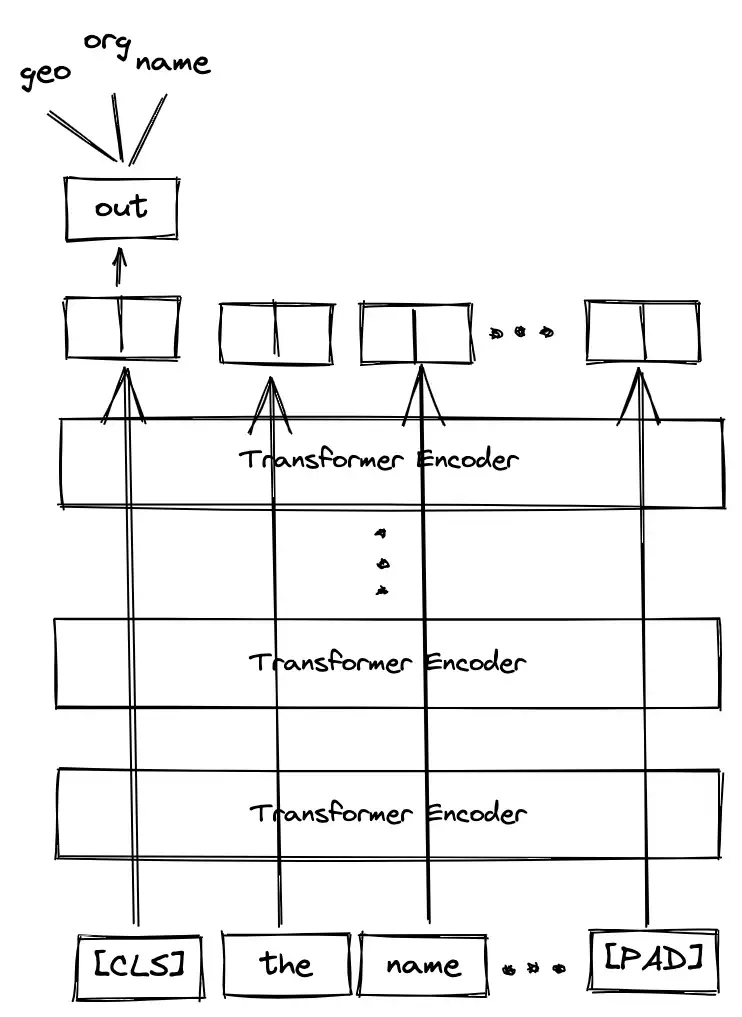

Meanwhile, if we want to use BERT for NER tasks, we need to use the embedding vector output from all of the tokens, as you can see in the visualization below:

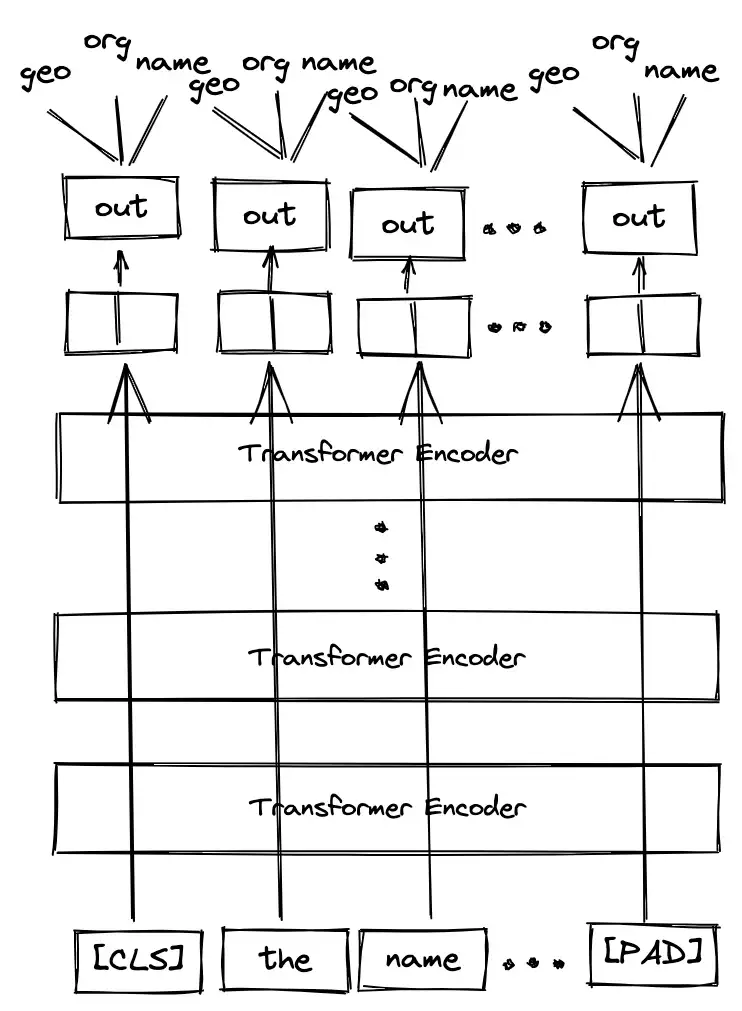

By using the embedding vector output from all of the tokens, then we can classify texts at the token level. This is exactly what we want since we want our BERT model to predict the entity if each token. Now without further ado, let's go to the implementation.

## About the Dataset

The dataset that we are going to use in this article is the CoNLL-2003 dataset, which is a dataset specifically used for NER task. You can download the data on Kaggle via the link below.

<a herf='https://www.kaggle.com/datasets/rajnathpatel/ner-data'> DATA LINK </a>

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('./data/ner.csv')
df

,text,labels
0,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
1,Iranian officials say they expect to get acces...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...
2,Helicopter gunships Saturday pounded militant ...,O O B-tim O O O O O B-geo O O O O O B-org O O ...
3,They left after a tense hour-long standoff wit...,O O O O O O O O O O O
4,U.N. relief coordinator Jan Egeland said Sunda...,B-geo O O B-per I-per O B-tim O B-geo O B-gpe ...
...,...,...
47954,Opposition leader Mir Hossein Mousavi has said...,O O O B-per I-per O O O O O O O O O O O O O O ...
47955,"On Thursday , Iranian state media published a ...",O B-tim O B-gpe O O O O O O O O B-org I-org O ...
47956,"Following Iran 's disputed June 12 elections ,...",O B-geo O O B-tim I-tim O O O O O O O O O O O ...
47957,"Since then , authorities have held public tria...",O O O O O O O O O O O O O O O O O O O O O


As we can see above, we have a dataframe which consists of the text and the label. The label corresponds to entity category of each word in a text.

In total, there are 9 entity categories, which are:

- "geo" for geographical entity
- "org" for organization entity
- "per" for person entity
- "gpe" for geopolitical entity
- "tim" for time indicator entity
- "art" for artifact entity
- "eve" for event entity
- "nat" for natural phenomenon entity
- "O" is assigned if a word doesn't belong to any entity

Let's take a look at the uniqye labels available on our dataset.

As you might notice, each entity category is preceeded with the letter "I" or "B". This corresponds to what previously mentioned as IOB tagging. "I" means Intermediate and "B" means Beginning.

In [3]:
# split labels based on whitespace and turn them into a list
labels = [i.split() for i in df['labels'].tolist()]

# check how may labels are there in the dataset
unique_labels = set()

for label_list in labels:
    for label in label_list:
        if label not in unique_labels:
            unique_labels.add(label)

# Map each label into its id representation and vice versa
labels_to_ids = {k:v for v,k in enumerate(sorted(unique_labels))}
ids_to_labels = {v:k for v,k in enumerate(sorted(unique_labels))}

print(labels_to_ids)

{'B-art': 0, 'B-eve': 1, 'B-geo': 2, 'B-gpe': 3, 'B-nat': 4, 'B-org': 5, 'B-per': 6, 'B-tim': 7, 'I-art': 8, 'I-eve': 9, 'I-geo': 10, 'I-gpe': 11, 'I-nat': 12, 'I-org': 13, 'I-per': 14, 'I-tim': 15, 'O': 16}


## Data Preprocessing

Before we are able to use a BERT model to classifify the entity of a token, of course, we need to do data preprocessing first, which includes two parts:
- tokenization
- adjusting the label to match the tokenization

### Tokenization

Tokenization can be easily implmented with BERT, as we can use "BertTokenizerFast" class from a pretrained BERT base model with HuggingFace.

In [4]:
# Tokenization Exapmle

texts = df['text'].tolist()
example = texts[0]

print(example)

Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .


In [5]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
text_tokenized = tokenizer(example, max_length=32, padding='max_length', truncation=True, return_tensors='pt')

print(text_tokenized)

{'input_ids': tensor([[  101, 26159,  1104,  8568,  4487,  5067,  1138,  9639,  1194,  1498,
          1106,  5641,  1103,  1594,  1107,  5008,  1105,  4555,  1103, 10602,
          1104,  1418,  2830,  1121,  1115,  1583,   119,   102,     0,     0,
             0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0]])}


In [6]:
print(tokenizer.decode(text_tokenized.input_ids[0]))

[CLS] Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country. [SEP] [PAD] [PAD] [PAD] [PAD]


### Adjusting Label After Tokenization

This is a very important step that we need to do after the tokenization process. This is because the length of the sequence is no longer matching the length of the original label after tokenization process.

The BERT tokenizer uses the so-called word-piece tokenizer under the hood, which is a sub-word tokenizer. This means that BERT tokenizer will likely to split one word into one or more mearingful sub-words.

In [7]:

print(tokenizer.convert_ids_to_tokens(text_tokenized["input_ids"][0]))


['[CLS]', 'Thousands', 'of', 'demons', '##tra', '##tors', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


There are two problems that we need to address after tokenization process
- The addition of special tokens from BERT such as [CLS], [SEP] and [PAD]
- The fact that some tokens are splitted into sub-words.

As sub-word tokenization, word-piece tokenization splits uncommon words into their sub-words. This sub-word tokenization helps the BERT model to learn the semantic meaning of related words.

The consequence of this word piece to tokenization and the addition of special tokens from BERT is that the sequence length after tokenization is no longer matching the length of the initial label.

To solve this problem. we need to adjust the label such that it has the same length as the sequence after tokenization. To do this, we can uilize the "word_ids" method from the tokenization result as follows:

In [8]:
word_ids = text_tokenized.word_ids()
print(tokenizer.convert_ids_to_tokens(text_tokenized['input_ids'][0]))
print(word_ids)

['[CLS]', 'Thousands', 'of', 'demons', '##tra', '##tors', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[None, 0, 1, 2, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, None, None, None, None, None]


As you can see from the code snippet above, each splitted token shares the same "word_ids", where special tokens from BERT such as [CLS],[SEP] and [PAD] all do not have specific "word_ids".

These "word_ids" will be very useful to adjust the length of the label by applying either of these two methods:

1. We only provide a label to the first sub-words of each splitted token. The continuation of the sub-word then will simply have "-100" as a label. All tokens that don't have "word_ids" will also be labeled with "-100".

2. We provide the same label amoing all of the sub-words that belong to the same token. All tokens that don't have "word_ids" will be labeled with "-100".

The function in the code snippet below will do exactly the step defined above.

In [9]:
def align_label_example(tokenized_input, labels, label_all_tokens=False):

    word_ids = tokenized_input.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]])
            except:
                label_ids.append(-100)
        
        else:
            # whether labeling the first sub-word token or not
            # if label_all_tokens sets False, only only the first sub-word token has label.
            if label_all_tokens:
                label_ids.append(labels_to_ids[labels[word_idx]])
            else:
                label_ids.append(-100)

        previous_word_idx = word_idx

    return label_ids

If you want to apply the first method, set "label_all_tokens" to False. If you want to apply the second method, set "label_all_tokens" tp True, as you can see in the following code snippet

In [10]:
label = labels[10]
text_tokenized = tokenizer(texts[10], max_length=32, padding='max_length', truncation=True, return_tensors='pt')

# If we set label_all_tokens to True
new_label = align_label_example(text_tokenized, label, label_all_tokens=True)

print(texts[10].split())
print(label)
print(new_label)
print(tokenizer.convert_ids_to_tokens(text_tokenized["input_ids"][0]))

['In', 'Beirut', ',', 'a', 'string', 'of', 'officials', 'voiced', 'their', 'anger', ',', 'while', 'at', 'the', 'United', 'Nations', 'summit', 'in', 'New', 'York', ',', 'Prime', 'Minister', 'Fouad', 'Siniora', 'said', 'the', 'Lebanese', 'people', 'are', 'resolute', 'in', 'preventing', 'such', 'attempts', 'from', 'destroying', 'their', 'spirit', '.']
['O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-org', 'I-org', 'O', 'O', 'B-geo', 'I-geo', 'O', 'B-per', 'O', 'B-per', 'I-per', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[-100, 16, 2, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 13, 16, 16, 2, 10, 16, 6, 16, 6, 6, 6, 14, 14, 14, 16, -100]
['[CLS]', 'In', 'Beirut', ',', 'a', 'string', 'of', 'officials', 'voiced', 'their', 'anger', ',', 'while', 'at', 'the', 'United', 'Nations', 'summit', 'in', 'New', 'York', ',', 'Prime', 'Minister', 'F', '##ou', '##ad', 'Sin', '##ior', '##a', 'said', '[SEP]']


In [11]:
label = labels[10]
text_tokenized = tokenizer(texts[10], max_length=32, padding='max_length', truncation=True, return_tensors='pt')

# If we set label_all_tokens to True
new_label = align_label_example(text_tokenized, label, label_all_tokens=False)

print(texts[10].split())
print(label)
print(new_label)
print(tokenizer.convert_ids_to_tokens(text_tokenized["input_ids"][0]))

['In', 'Beirut', ',', 'a', 'string', 'of', 'officials', 'voiced', 'their', 'anger', ',', 'while', 'at', 'the', 'United', 'Nations', 'summit', 'in', 'New', 'York', ',', 'Prime', 'Minister', 'Fouad', 'Siniora', 'said', 'the', 'Lebanese', 'people', 'are', 'resolute', 'in', 'preventing', 'such', 'attempts', 'from', 'destroying', 'their', 'spirit', '.']
['O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-org', 'I-org', 'O', 'O', 'B-geo', 'I-geo', 'O', 'B-per', 'O', 'B-per', 'I-per', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[-100, 16, 2, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 13, 16, 16, 2, 10, 16, 6, 16, 6, -100, -100, 14, -100, -100, 16, -100]
['[CLS]', 'In', 'Beirut', ',', 'a', 'string', 'of', 'officials', 'voiced', 'their', 'anger', ',', 'while', 'at', 'the', 'United', 'Nations', 'summit', 'in', 'New', 'York', ',', 'Prime', 'Minister', 'F', '##ou', '##ad', 'Sin', '##ior', '##a', 'said', '[SEP]']


In the rest of this article, we are going to to implment the first method, in which we will only provide a label to firsh sub-word in each token and set "label_all_tokens" to False.

## Dataset Class

Befor we train our BERT model for NER Task, ew need to create a dataset class to generate and fetch data in a batch.

In [12]:
import torch
def align_label(texts, labels, label_all_tokens=False):
    tokenized_inputs = tokenizer(texts, max_length=128, padding='max_length', truncation=True)

    word_ids = tokenized_inputs.word_ids()
    
    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]])
            except:
                label_ids.append(-100)

        else:
            try:
                if label_all_tokens:
                    label_ids.append(labels_to_ids[labels[word_idx]])
                else:
                    label_ids.append(-100)
            except:
                label_ids.append(-100)

        previous_word_idx = word_idx

    return label_ids

In [13]:
class DataSequence(torch.utils.data.Dataset):
    def __init__(self, df, max_length=128, model_name='bert-base-cased'):

        lb = [i.split() for i in df['labels'].tolist()]
        txt = df['text'].tolist()
        
        self.tokenizer = BertTokenizerFast.from_pretrained(model_name)
        self.max_length = max_length

        self.text = [self.tokenizer(str(i), max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt') for i in txt]
        self.labels = [align_label(i,j) for i,j in zip(txt, lb)]

    def __len__(self):
        return len(self.labels)

    def get_batch_data(self, idx):
        return self.text[idx]

    def get_batch_labels(self,idx):
        return torch.LongTensor(self.labels[idx])

    def __getitem__(self,idx):

        batch_data = self.get_batch_data(idx)
        batch_labels = self.get_batch_labels(idx)

        return batch_data, batch_labels

In the code snippet above, we call "BertTokenizerFast" class with tokenizer variable in the "\_\_init\_\_" function to tokenize our input texts, and "align_label" function to adjust our label after tokenization process.

Next, let's split out data randomly into training, validation and text. However, mind you that the total number of data is 47959. Hence, for demonstration purpose and to speed up the raining process, I'm going to take only 1000 of them.



In [14]:
import numpy as np

#df = df[0:1000]
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), [int(0.8*len(df)),int(0.9*len(df))])

## Model Building

In this article, we are going to use a pretrained BERT base model from HuggingFace. Since we are going to classify text in the token level, then we need to use "BertForTokenClassification" class.

"BertForTokenClassification" class is a model that wraps BERT model and adds linear layers on top of BERT model that will act as token-level classifiers.

https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForTokenClassification
https://github.com/huggingface/transformers/blob/v4.26.0/src/transformers/models/bert/modeling_bert.py#L1715

In [15]:
from transformers import BertForTokenClassification

class BertModel(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.bert = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(unique_labels))

    def forward(self, input_id, mask, label):
        output = self.bert(input_ids = input_id, attention_mask=mask, labels=label, return_dict=False)

        return output

## Training Loop

The training loop for our BERT model is the standard PyTorch training loop with a few additions, as you can see below:

In [16]:
from tqdm import tqdm

def train_loop(model, df_train, df_val, BATCH_SIZE=4, LEARNING_RATE=2e-5, EPOCHES=5):

    train_dataset = DataSequence(df_train)
    val_dataset = DataSequence(df_val)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    if use_cuda:
        model = model.cuda()

    best_acc = 0
    best_loss = 2e10

    for epoch_num in range(EPOCHES):

        total_acc_train = 0
        total_loss_train = 0

        model.train()

        for train_data, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_data['attention_mask'].squeeze(1).to(device)
            input_id = train_data['input_ids'].squeeze(1).to(device)

            optimizer.zero_grad()

            loss, logits = model(input_id, mask, train_label)

            for i in range(logits.shape[0]):
                logits_clean = logits[i][train_label[i] != -100]
                label_clean = train_label[i][train_label[i] != -100]

                predictions = logits_clean.argmax(dim=1)

                acc = (predictions == label_clean).float().mean()

                total_acc_train += acc
                total_loss_train += loss.item()
            
            loss.backward()
            optimizer.step()

        
        model.eval()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_data, val_label in val_dataloader:


                val_label = val_label.to(device)
                mask = val_data['attention_mask'].squeeze(1).to(device)
                input_id = val_data['input_ids'].squeeze(1).to(device)

                loss, logits = model(input_id, mask, val_label)

                for i in range(logits.shape[0]):
                    logits_clean = logits[i][val_label[i] != -100]
                    label_clean = val_label[i][val_label[i] != -100]

                    predictions = logits_clean.argmax(dim=1)
                    acc = (predictions == label_clean).float().mean()

                    total_acc_val += acc
                    total_loss_val += loss.item()

                val_accuracy = total_acc_val / len(df_val)
                val_loss = total_loss_val / len(df_val)

        print(f'Epochs: {epoch_num + 1} | Loss: {total_loss_train / len(df_train): .3f} | Accuracy: {total_acc_train / len(df_train): .3f} | Val_Loss: {total_loss_val / len(df_val): .3f} | Accuracy: {total_acc_val / len(df_val): .3f}')            

In [17]:
model = BertModel()
train_loop(model, df_train, df_val)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Epochs: 1 | Loss:  0.184 | Accuracy:  0.946 | Val_Loss:  0.128 | Accuracy:  0.962


100%|██████████| 9592/9592 [15:25<00:00, 10.36it/s]


Epochs: 2 | Loss:  0.111 | Accuracy:  0.966 | Val_Loss:  0.113 | Accuracy:  0.966


100%|██████████| 9592/9592 [15:25<00:00, 10.36it/s]


Epochs: 3 | Loss:  0.086 | Accuracy:  0.973 | Val_Loss:  0.119 | Accuracy:  0.964


100%|██████████| 9592/9592 [15:25<00:00, 10.36it/s]


Epochs: 4 | Loss:  0.067 | Accuracy:  0.978 | Val_Loss:  0.114 | Accuracy:  0.966


100%|██████████| 9592/9592 [15:25<00:00, 10.36it/s]


Epochs: 5 | Loss:  0.054 | Accuracy:  0.982 | Val_Loss:  0.121 | Accuracy:  0.967


There are a lot of things that you can do to improve the performance of our model. If you notice, we have a data imbalance problem as there are a lot of token with "O" label. We can improve our model, for example, by applying class weights during the training process.

## Evaluate Model on Test Data

Now that we have trained our model, we can evaluate its performance on unseen test data with the following code sinppet.

In [24]:
def evaluate(model, df_test):

    test_dataset = DataSequence(df_test)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0.0

    with torch.no_grad():
        for test_data, test_label in tqdm(test_dataloader):

            test_label = test_label.to(device)

            mask = test_data["attention_mask"].squeeze(1).to(device)
            input_id = test_data["input_ids"].squeeze(1).to(device)

            loss, logits = model(input_id, mask, test_label)

            for i in range(logits.shape[0]):

                logits_clean = logits[i][test_label[i] != -100]
                label_clean = test_label[i][test_label[i] != -100]

                predictions = logits_clean.argmax(dim=1)
                acc = (predictions == label_clean).float().mean()

                total_acc_test += acc

        val_accuracy = total_acc_test / len(df_test)
        print(f'Test Accuracy: {total_acc_test / len(df_test): .3f}')

In [25]:
evaluate(model, df_test)

100%|██████████| 4796/4796 [00:49<00:00, 97.14it/s] 

Test Accuracy:  0.969


In my case, the trained model achieved an average of 96.9% accuracy on the test set. You can of course, change the metrics to F1 score, precision or recall.

Alternatively, we can use the trained model to predict the entity of each word of a text or a sentence with the following code:

In [32]:
def align_word_ids(texts, label_all_tokens=False):

    tokenized_input = tokenizer(texts, max_length=512, padding='max_length', truncation=True)

    word_ids = tokenized_input.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(1)
            except:
                label_ids.append(-100)

        else:
            try:
                label_ids.append(1 if label_all_tokens else -100)
            except:
                label_ids.append(-100)

        previous_word_idx = word_idx

    return label_ids

In [35]:
def evaluate_one_text(model, sentence):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()
    
    model.eval()

    text = tokenizer(sentence, max_length=512, padding='max_length', truncation=True, return_tensors='pt')

    mask = text['attention_mask'].to(device)
    input_id = text['input_ids'].to(device)

    label_ids = torch.Tensor(align_word_ids(sentence)).unsqueeze(0).to(device)

    logits = model(input_id, mask, None)
    logits_clean = logits[0][label_ids != -100]

    predictions = logits_clean.argmax(dim=1).tolist()
    prediction_label = [ids_to_labels[i] for i in predictions]

    print(sentence)
    print(prediction_label)

In [39]:
evaluate_one_text(model, 'Bill who uses an iPhone bought from Apple eats an apple')

Bill who uses an iPhone bought from Apple eats an apple
['B-per', 'O', 'O', 'O', 'B-art', 'O', 'O', 'B-org', 'O', 'O', 'O']
